In [1]:
import os
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw

## Read data

In [2]:
DATA_PATH='data/raw/'
files=[fl for fl in os.listdir(DATA_PATH) if fl.endswith('.txt')]

txt=''
for fl in files:
    txt_=Path(DATA_PATH+fl).read_text().lower()
    
    txt_=txt_.replace('\n', '').replace('.', ' ').replace(',', ' ').replace('!', ' ').\
    replace('?', ' ').replace(':', ' ').replace(';', ' ').replace('™', ' ').replace('¶', ' ').\
    replace('(', ' ').replace(')', ' ').replace(']', ' ').replace('[', ' ').replace('„', ' ').\
    replace('“', ' ').replace('•', ' ').replace('¼', ' ').replace('¤', ' ')
    txt=f'{txt} {txt_}'

In [3]:
txt[:10]

' see oli l'

## Count char freq

In [4]:
cnt=Counter(txt.split())
len(cnt)

3572

In [5]:
df_cnt=pd.DataFrame(cnt.most_common(len(cnt)))
df_cnt.columns=['token', 'count']
df_cnt['prob']=np.divide(df_cnt['count'], df_cnt['count'].sum())
df_cnt['count_log']=np.log(df_cnt['count'])
df_cnt['prob_log']=np.log(df_cnt['prob'])
df_cnt.head()

,token,count,prob,count_log,prob_log
0,ã,452,0.037573,6.113682,-3.281477
1,ja,310,0.025769,5.736572,-3.658587
2,ta,192,0.015960,5.257495,-4.137663
3,kã,185,0.015378,5.220356,-4.174803
4,â€œ,156,0.012968,5.049856,-4.345303


<AxesSubplot:>

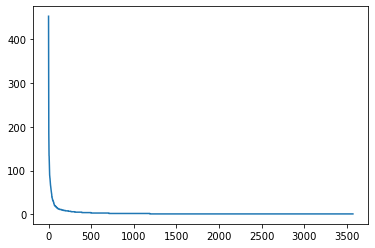

In [6]:
df_cnt['count'].plot()

<AxesSubplot:>

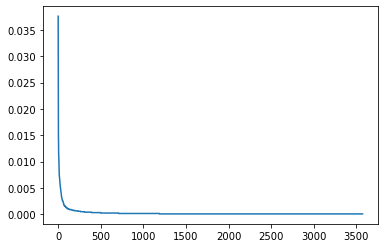

In [7]:
df_cnt['prob'].plot()

<AxesSubplot:>

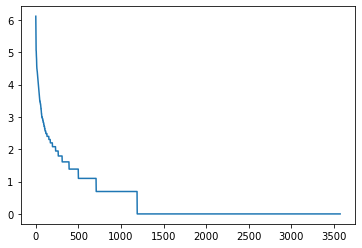

In [8]:
df_cnt['count_log'].plot()

<AxesSubplot:>

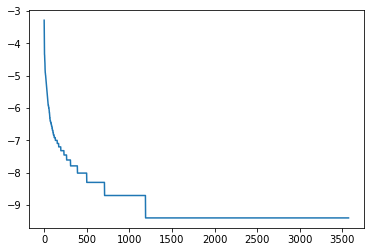

In [9]:
df_cnt['prob_log'].plot()

<AxesSubplot:xlabel='count_log', ylabel='prob_log'>

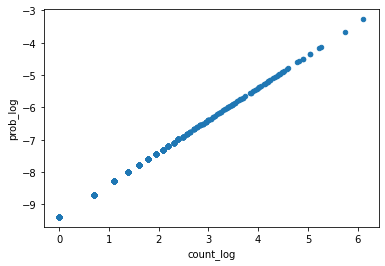

In [10]:
df_cnt.plot.scatter('count_log','prob_log')

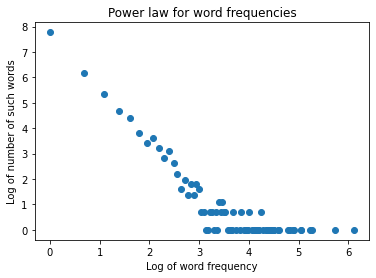

In [11]:
counter_of_words = Counter(txt.split())
counter_of_counts = Counter(counter_of_words.values())
word_counts = np.array(list(counter_of_counts.keys()))
freq_of_word_counts = np.array(list(counter_of_counts.values()))
plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
plt.xlabel('Log of word frequency')
plt.ylabel('Log of number of such words')
plt.title('Power law for word frequencies')
plt.show();

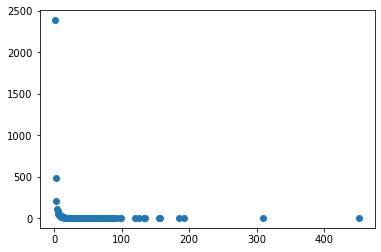

In [12]:
plt.scatter(word_counts, freq_of_word_counts)

## Estimate slope

In [13]:
def neg_zipf_likelihood(s):
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood

from scipy.optimize import minimize_scalar
s_best = minimize_scalar(neg_zipf_likelihood, [0.1, 3.0] )
print(s_best.x)

0.8792971547915152


## Exponential vs power law

In [14]:
x=np.arange(1, 1000)[::-1]
const=3
y_p=0.000003*x**const
y_e=1.01**x

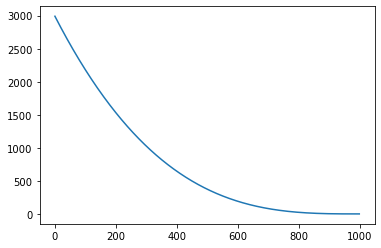

In [15]:
plt.plot(y_p)

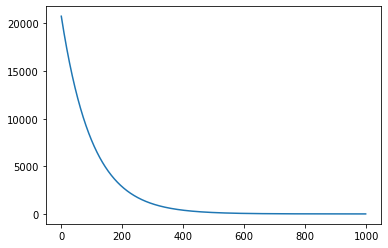

In [16]:
plt.plot(y_e)

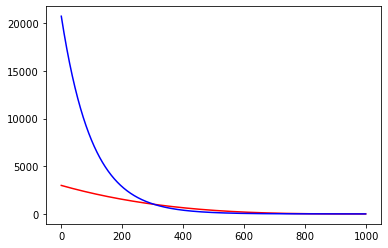

In [17]:
plt.plot(y_p, color='red')
plt.plot(y_e, color='blue')

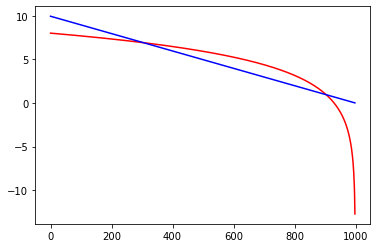

In [18]:
plt.plot(np.log(y_p), color='red')
plt.plot(np.log(y_e), color='blue')

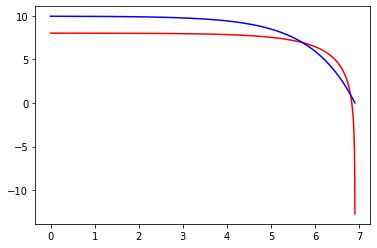

In [19]:
plt.plot(np.log(x)[::-1], np.log(y_p), color='red')
plt.plot(np.log(x)[::-1], np.log(y_e), color='blue')

## Example: https://notebook.community/puolival/power-law/powerlaw

In [20]:
def random(size=1, xmin=1, alpha=1.5):
    """Draw random numbers from a power-law distribution using the inverse
    random sampling method.

    Input arguments:
    size  - Sample size
    xmin  - Minimum value for which the power-law holds
    alpha - Scaling exponent of the power-law distribution
    """
    rvs = np.random.random(size=size)
    return float(xmin) * (1.-rvs) ** (-1. / (float(alpha)-1.))

In [21]:
-1. / (float(2.5)-1.)

-0.6666666666666666

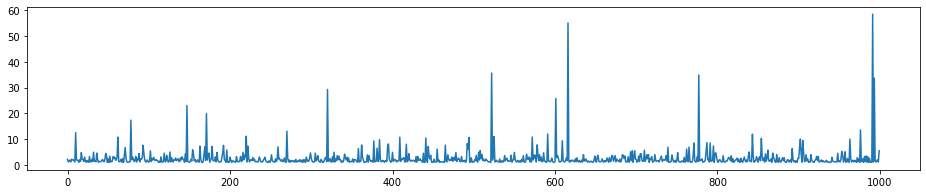

In [22]:
rvs = random(size=1000, xmin=1, alpha=2.5)
plt.figure(figsize=(16, 3)); 
plt.plot(rvs); 
plt.show()

In [23]:
def plot_ccdf(rvs):
    """Plot complementary cumulative distribution function (CCDF) of
    a possibly power-law distributed sample.

    Input arguments:
    rvs   - Analyzed random sample
    """
    # Calculate complementary CDF
    n = np.size(rvs)
    xcdf, ycdf = np.sort(rvs), np.arange(n, 0, -1) / float(n)

    # Visualize the CDF
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(111)
    ax1.loglog(xcdf, ycdf, 'o', fillstyle='none')

def mle_alpha(rvs, xmin):
    """Maximum likelihood (ML) estimate of the scaling parameter
    alpha."""
    # Select observation larger than or equal to xmin
    rvs = rvs[rvs>=xmin]
    n = np.size(rvs)

    return 1. + n * (1. / np.sum(np.log(rvs / float(xmin))))

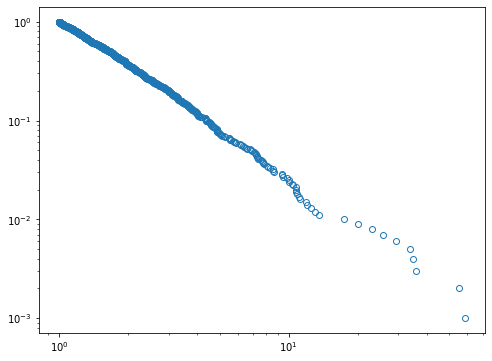

In [24]:
plot_ccdf(rvs)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_55072\3915412209.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.sort(rvs)), np.log((np.array(list(range(len(rvs))))/len(rvs))[::-1]), 'bo')


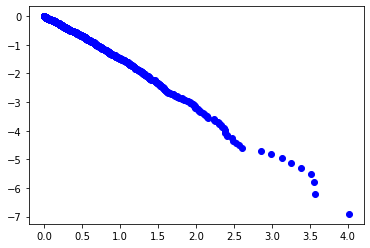

In [25]:
plt.plot(np.log(np.sort(rvs)), np.log((np.array(list(range(len(rvs))))/len(rvs))[::-1]), 'bo')

In [26]:
#scaling parameter
mle_alpha(rvs, xmin=1)

2.50498591391407

## How mean changes when number of samples change

In [27]:
np.random.seed(134)

def gen_data(func, xmin=5.0, parameters=[2.5], num_samples=1000000):
    dist=func(xmin=xmin, parameters=parameters)
    data = dist.generate_random(1000000)
    return data

In [28]:
exp_data=gen_data(powerlaw.Exponential, xmin=5.0, parameters=[0.4])
power_data=gen_data(powerlaw.Power_Law, xmin=5.0, parameters=[2.5])

In [29]:
# power_dist = powerlaw.Power_Law(xmin=5.0, parameters=[2.5])
# exp_dist = powerlaw.Exponential(xmin=5.0, parameters=[0.4])
# theoretical_distribution = powerlaw.Power_Law(xmin=5.0, parameters=[2.5])

In [30]:
# exp_data = exp_dist.generate_random(1000000)
# power_data = power_dist.generate_random(1000000)
power_data

array([16.34534155,  6.55873127, 10.10879302, ...,  6.2620059 ,
        8.64041142, 65.70130088])

In [31]:
exp_data

array([ 9.17036534,  6.48445058,  7.47044485, ...,  6.82056206,
       16.82753418,  5.40356592])

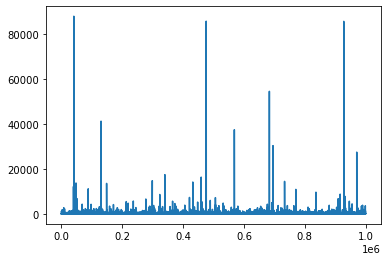

In [32]:
plt.plot(power_data)

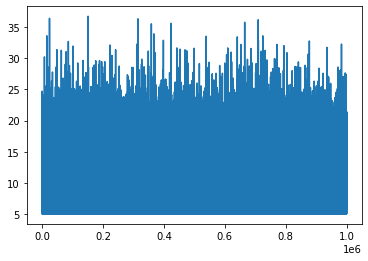

In [33]:
plt.plot(exp_data)

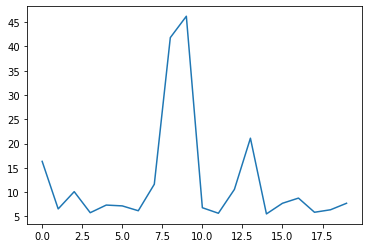

In [34]:
#plot only first samples
plt.plot(power_data[:20])

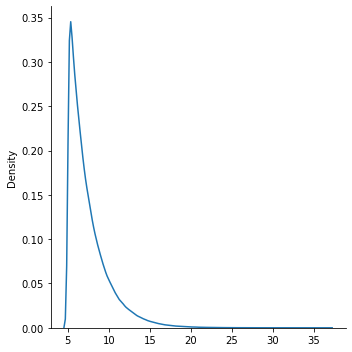

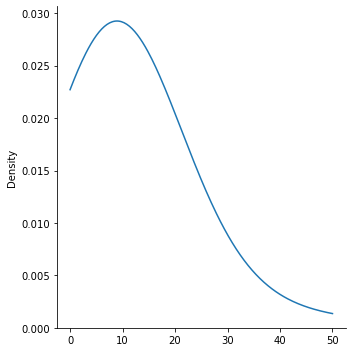

In [35]:
sns.displot(exp_data, kind="kde")
sns.displot(power_data, kind="kde", clip=(0.0, 50.0))

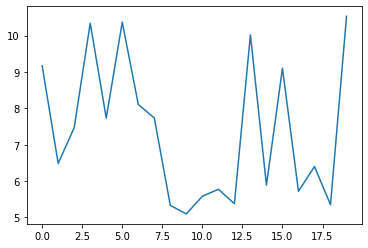

In [36]:
plt.plot(exp_data[:20])

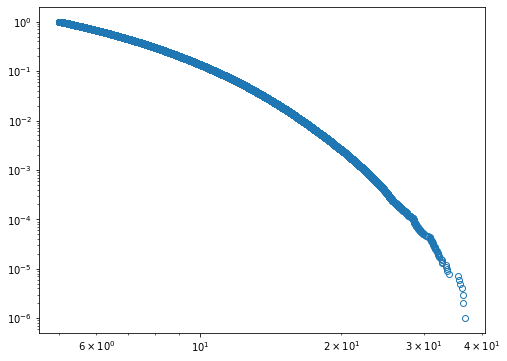

In [37]:
plot_ccdf(exp_data)

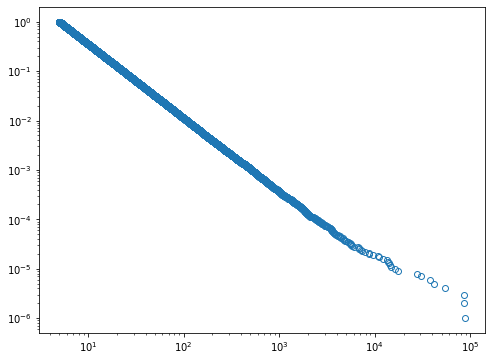

In [38]:
plot_ccdf(power_data)

In [39]:
def sample_dist_stats(power_data, exp_data, sample_sizes):
    data=[]
    for size in sample_sizes:
        power_samp=np.random.choice(power_data, size=size, replace=False)
        exp_samp=np.random.choice(exp_data, size=size, replace=False)
        data.append({'sample_size':size,
                     'power_max': np.max(power_samp),
                     'power_mean':np.mean(power_samp),
                     'power_median': np.median(power_samp),
                     'power_std': np.std(power_samp),
                     'exp_max':np.max(exp_samp),
                     'exp_mean':np.mean(exp_samp),
                     'exp_median':np.median(exp_samp),
                     'exp_std':np.std(exp_samp)})

    df_power_exp=pd.DataFrame(data)
    df_power_exp=df_power_exp.set_index(df_power_exp['sample_size'])
    return df_power_exp

In [75]:
np.random.seed(1028)
exp_data=gen_data(powerlaw.Exponential, xmin=5.0, parameters=[0.4])
power_data=gen_data(powerlaw.Power_Law, xmin=5.0, parameters=[2.5])

df_power_exp=sample_dist_stats(power_data, exp_data, sample_sizes=[10**i for i in range(1, 7)])

In [76]:
df_power_exp

,sample_size,power_max,power_mean,power_median,power_std,exp_max,exp_mean,exp_median,exp_std
sample_size,,,,,,,,,
10,10,49.323659,16.873614,11.255661,13.279084,16.338039,8.391254,7.092426,3.246849
100,100,40.572080,10.762041,8.287225,6.294382,17.838745,7.544956,6.571791,2.585605
1000,1000,261.465514,13.516896,7.872147,20.143146,21.470280,7.556451,6.795857,2.558708
10000,10000,1259.336401,13.845998,7.882485,29.494499,27.680058,7.482514,6.681784,2.502188
100000,100000,9069.012110,14.810846,7.953863,63.015548,39.699036,7.511860,6.731256,2.508317
1000000,1000000,177888.893359,15.008575,7.936116,191.375065,40.501126,7.500247,6.730384,2.502584


(0.0, 20.0)

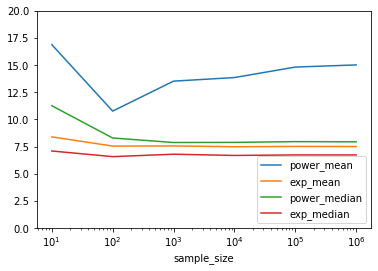

In [83]:
df_power_exp[['power_mean', 'exp_mean', 'power_median', 'exp_median']].plot()
plt.xscale('log')
plt.ylim((0,20))

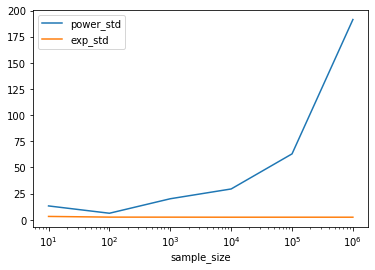

In [85]:
df_power_exp[['power_std', 'exp_std']].plot()
plt.xscale('log')
# plt.ylim((0,20))

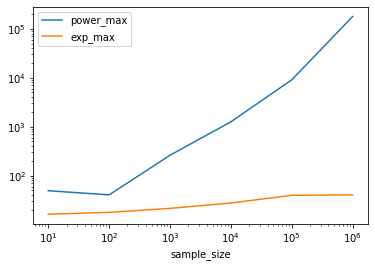

In [87]:
#maximum value we have seen is hugeliy bigger under powerlaw distribution
df_power_exp[['power_max', 'exp_max']].plot()
plt.yscale('log')
plt.xscale('log')

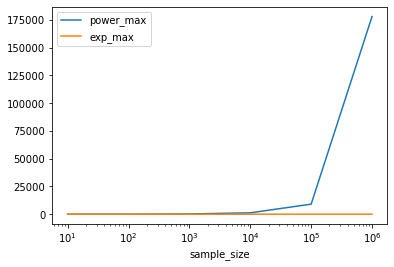

In [88]:
df_power_exp[['power_max', 'exp_max']].plot()
plt.xscale('log')

<AxesSubplot:xlabel='sample_size'>

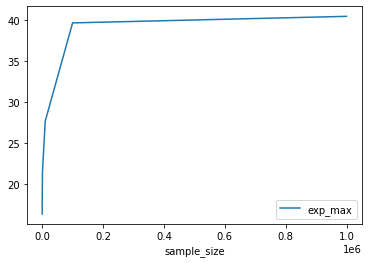

In [79]:
#in a different scale exponential function maximums have also big growth, but they are a lot smaller
df_power_exp[['exp_max']].plot()

## Different params for powerlaw function

In [44]:
exp_data2=gen_data(powerlaw.Exponential, xmin=5.0, parameters=[0.1], num_samples=1e8)
power_data2=gen_data(powerlaw.Power_Law, xmin=5.0, parameters=[1.9999], num_samples=1e8)

df_power_exp2=sample_dist_stats(power_data2, exp_data2, sample_sizes=[10**i for i in range(1, 7)])

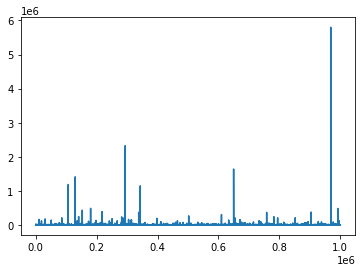

In [45]:
plt.plot(power_data2)

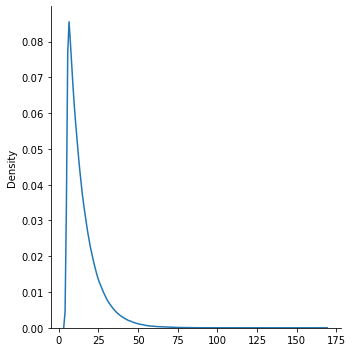

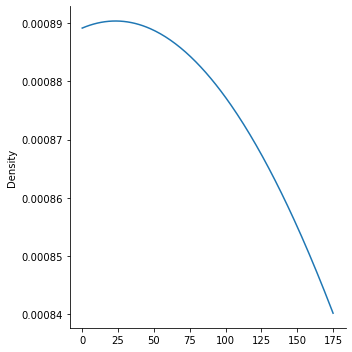

In [53]:
sns.displot(exp_data2, kind="kde")
sns.displot(power_data2, kind="kde", clip=(0,175))

C:\Users\RistoHinno\anaconda3\lib\site-packages\seaborn\distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
C:\Users\RistoHinno\anaconda3\lib\site-packages\seaborn\distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


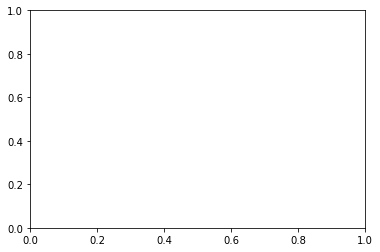

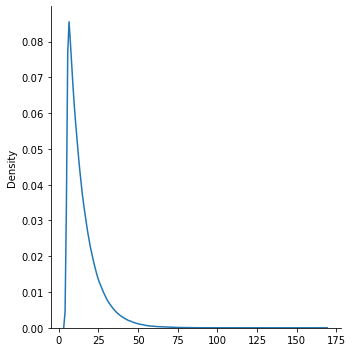

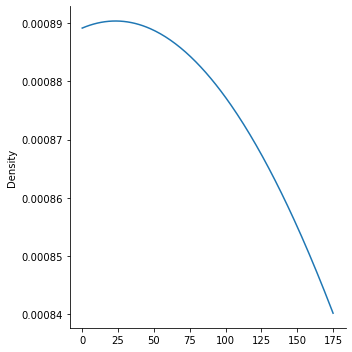

In [91]:
fig, ax =plt.subplots()
ax=sns.displot(exp_data2, kind="kde", ax=ax)
ax=sns.displot(power_data2, kind="kde", ax=ax, clip=(0,175))

In [47]:
exp_data2

array([15.32594903,  6.05596969,  9.37173102, ..., 12.23172797,
       11.00554747, 54.04970237])

In [48]:
df_power_exp2

,sample_size,power_max,power_mean,power_median,power_std,exp_max,exp_mean,exp_median,exp_std
sample_size,,,,,,,,,
10,10,2.806073e+01,9.353185,7.235828,6.475664,37.877418,16.696422,12.110960,10.261684
100,100,3.728015e+03,63.218748,10.417651,374.324470,45.524050,14.067943,11.916817,8.286065
1000,1000,1.356459e+04,48.298224,10.198815,449.609226,96.908835,14.997087,11.930025,10.203997
10000,10000,4.409393e+04,39.752424,9.999845,492.726796,94.896406,14.974158,11.968564,9.960330
100000,100000,4.335131e+05,60.361750,10.015918,1781.798389,145.223285,15.015937,11.963143,9.957153
1000000,1000000,5.801057e+06,71.034463,9.992429,7010.856234,167.457292,15.015162,11.936730,10.021770


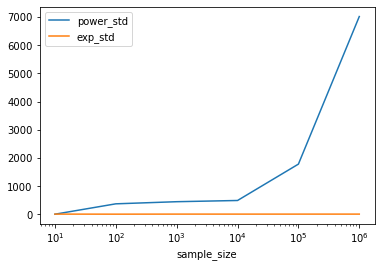

In [89]:
df_power_exp2[['power_std', 'exp_std']].plot()
plt.xscale('log')

## Extreme value

In [50]:
N=1000
maxes=[]
for i in range(N):
    power_data_ = gen_data(powerlaw.Power_Law, xmin=5.0, parameters=[2.5])
    maxes.append(power_data_.max())

(array([769., 137.,  32.,  19.,  14.,   7.,   4.,   1.,   1.,   4.,   2.,
          1.,   1.,   0.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   12123.23370761,   116188.63261441,   220254.03152121,
          324319.43042802,   428384.82933482,   532450.22824162,
          636515.62714842,   740581.02605522,   844646.42496203,
          948711.82386883,  1052777.22277563,  1156842.62168243,
         1260908.02058923,  1364973.41949603,  1469038.818

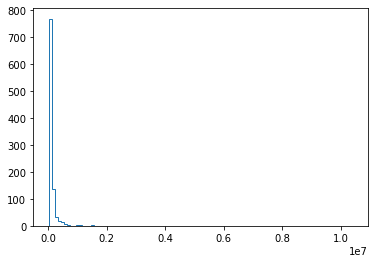

In [51]:
plt.hist(maxes, bins=100, histtype='step')

(array([ 769.,  906.,  938.,  957.,  971.,  978.,  982.,  983.,  984.,
         988.,  990.,  991.,  992.,  992.,  995.,  996.,  997.,  997.,
         997.,  997.,  997.,  997.,  997.,  997.,  997.,  997.,  997.,
         997.,  997.,  998.,  998.,  998.,  998.,  998.,  998.,  999.,
         999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,
         999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,
         999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,
         999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,
         999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,
         999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,
         999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,  999.,
        1000.]),
 array([   12123.23370761,   116188.63261441,   220254.03152121,
          324319.43042802,   428384.82933482,   532450.22824162,
          636515.62714842,   740581.02605522,   844646.42496203,
       

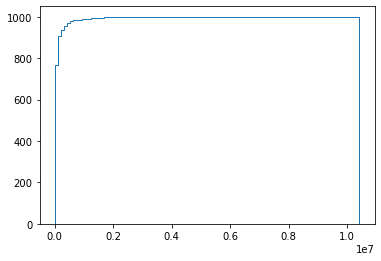

In [52]:
plt.hist(maxes, bins=100, cumulative=True, histtype='step')